# MECANISMO CINCO BARRAS 

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

##### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_5B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('MECANISMO DE CUATRO BARRAS')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3:'))
meca["L4"] = float (input ('Introduce longitud L4: '))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["beta"] = float (input('Introduce angulo inicial beta: ')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [meca["L1"]], [1], [0.2], [2], [0.1], [meca["theta"]], [meca["beta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((8,8))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = -2*(X3-X2)
    Jacob[2,3] = -2*(Y3-Y2)
    Jacob[2,4] = 2*(X3-X2)
    Jacob[2,5] = 2*(Y3-Y2)
    Jacob[3,4] = -2*(meca["XB"]-X3)
    Jacob[3,5] = -2*(meca["YB"]-Y3)

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Jacob[4,6] = meca["L1"]*math.sin(theta)
        Jacob[4,0] = 1
    else:
        Jacob[4,6] = -meca["L1"]*math.cos(theta)
        Jacob[4,1] = 1


    if ((math.cos(beta)) < (math.sqrt(2)/2) ):
        Jacob[5,7] = meca["L4"]*math.sin(beta)
        Jacob[5,4] = 1
    else:
        Jacob[5,7] = -meca["L4"]*math.cos(beta)
        Jacob[5,5] = 1

    Jacob[6,6] = 1
    Jacob[7,7] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((8,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
	
    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (X3-X2)**2 + (Y3-Y2)**2 - meca["L3"]**2
    Phi[3] = (meca["XB"] - X3)**2 + (meca["YB"] - Y3)**2 - meca["L4"]**2

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Phi[4] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[4] = Y1-meca["L1"]*math.sin(theta)
		
    if (abs(math.cos(beta)) < (math.sqrt(2)/2) ):
        Phi[5] = (X3-meca["XB"])-meca["L4"]*math.cos(beta)
    else: 
        Phi[5] = Y3-meca["L4"]*math.sin(beta)
		
    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((8,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):



        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        X3 = q[4]
        Y3 = q[5]
        theta = q[6]
        beta = q[7]
       
        fi=Phi(q,meca)

        J = jacob_Phiq(q,meca)
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1

    return q


J = jacob_Phiq(q,meca)
print ("Jacob=")
pprint.pprint(J)

MECANISMO DE CUATRO BARRAS
Introduce longitud L1:1
Introduce longitud L2:2
Introduce longitud L3:2
Introduce longitud L4: 1
Introduce angulo inicial theta:0
Introduce angulo inicial beta: 0
Introduce coordenada en x del punto B:3
q: [[0.1]
 [1. ]
 [1. ]
 [0.2]
 [2. ]
 [0.1]
 [0. ]
 [0. ]]
Jacob=
array([[ 0.2,  2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-1.8,  1.6,  1.8, -1.6,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -2. ,  0.2,  2. , -0.2,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -2. ,  0.2,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. , -1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

#Фq · q_p = -Ф_p$

Siendo $q_p$ el vector velocidad, $Фq$ el jacobiano y $Ф_p$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

En este caso vamos a tomar un valor de $1$. 

Por lo tanto, tendríamos:

$q_p = Фq/Ф_p$

In [2]:
# PASO 2

def resuelve_prob_velocidad(q,meca):
    
    b = np.zeros ((8,1))
    #Velocidad del gdl.
    b[6]=0.2
    b[7] = 0.2
    qp = np.linalg.solve(jacob_Phiq(q,meca),b)
 
    return qp
	
resuelve_prob_velocidad (q,meca)

array([[-2.        ],
       [ 0.2       ],
       [ 0.27605634],
       [ 2.76056338],
       [ 0.02      ],
       [ 0.2       ],
       [ 0.2       ],
       [ 0.2       ]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $q_p$ y las aceleraciones de los grados de libertad. 

La ecuación de la que partimos es:

$Фq · q_pp = -∂_Фq · q_p$

Siendo Фq el jacobiano, q_pp el vector aceleración, q_p el vector velocidad y ∂_Фq la derivada del jacobiano respecto al tiempo. 

Es decir, si llamamos &b& al conjunto $∂_Фq · q_p$ tendríamos como resultado:

$q_pp = -Фq/b$

El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
X_1q \\
Y_1q \\
X_2q \\
Y_2q \\
X_3q \\
Y_3q \\
θ_q\\
\beta_q \\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas independientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

¡¡¡¡ COMPLETAR !!!!

Como ya tenemos $∂_Фq$ y $q_p$, podemos calcular &b&. La última fila que añadimos es el valor de la aceleración angular, dato que sabemos de antemano. 

In [3]:
#PASO 3

def resuelve_prob_aceleracion (q,meca):

    b=np.zeros ((8,1))
    qp = resuelve_prob_velocidad (q,meca)
	
	#Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    X3q = qp[4]
    Y3q = qp[5]
    thetaq = qp[6]
    betaq = qp[7]
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q-Y1q) + 2*X2q*(X2q*X1q) + 2*Y2q*(Y2q*Y1q)
    b[2] = -2*X2q*(X3q-X2q) + 2*Y2q*Y3q + 2*X3q*(X3q-X2q) + 2*Y3q*(Y3q-Y2q)
    b[3] = -2*X3q**2 - 2*Y3q**2
    
    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        b[4] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[4] =  thetaq**2 * (meca["L1"] * math.sin(theta))
    
    if (abs(math.cos(beta)) < (math.sqrt(2)/2) ):
        b[5] = betaq**2 * (meca["L4"] * math.cos(beta))
    else: 
        b[5] =  betaq**2 * (meca["L4"] * math.sin(beta))
		
    b[6] = 1 #Aceleracion conocida 
    b[7] = 1
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)

     
    return qpp

resuelve_prob_aceleracion(q, meca)

array([[-30.4       ],
       [ -1.        ],
       [  4.57648544],
       [ 45.11320591],
       [ -0.1404    ],
       [ -1.        ],
       [ -1.        ],
       [ -1.        ]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2, ~ Y_2, ~ X_3 ~ e ~ Y_3)$.


VX1=
array([-2.        , -1.98357995, -1.93458942, -1.85383284, -1.74263623,
       -1.60282545, -1.4366962 , -0.15636656, -0.1710288 , -0.18288274,
       -0.19173374, -0.19743646, -0.19989727, -0.19907575, -0.1949854 ,
       -0.18769337, -0.17731942, -0.16403387, -0.14805487,  1.5228993 ,
        1.67618275,  1.8019432 ,  1.89811565,  1.96312095,  1.99589171,
        1.99588982,  1.96311533,  1.89810639,  1.80193045,  1.67616672,
        1.52288025,  0.14805685,  0.16403555,  0.17732078,  0.18769439,
        0.19498605,  0.19907603,  0.19989717,  0.19743599,  0.19173291,
        0.18288155,  0.17102728,  0.15636473, -1.43671664, -1.60284303,
       -1.74265065, -1.85384387, -1.93459688, -1.98358371, -2.        ])


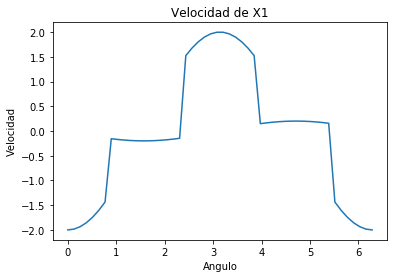

In [4]:
#PASO 4: VELOCIDAD DE X1

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VX1 = np.append(VX1, qp[0])

        i=i+1
      
    print ("VX1=")
    pprint.pprint(VX1)
 
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY1=
array([ 0.2       ,  0.198358  ,  0.19345894,  0.18538328,  0.17426362,
        0.16028255,  0.14366962,  0.01563666,  0.01710288,  0.01828827,
        0.01917337,  0.01974365,  0.01998973,  0.01990757,  0.01949854,
        0.01876934,  0.01773194,  0.01640339,  0.01480549, -0.15228993,
       -0.16761828, -0.18019432, -0.18981157, -0.1963121 , -0.19958917,
       -0.19958898, -0.19631153, -0.18981064, -0.18019305, -0.16761667,
       -0.15228803, -0.01480568, -0.01640355, -0.01773208, -0.01876944,
       -0.0194986 , -0.0199076 , -0.01998972, -0.0197436 , -0.01917329,
       -0.01828816, -0.01710273, -0.01563647,  0.14367166,  0.1602843 ,
        0.17426507,  0.18538439,  0.19345969,  0.19835837,  0.2       ])


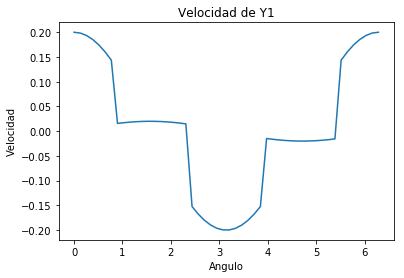

In [5]:
#PASO 4: VELOCIDAD DE Y1

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VY1 = np.append(VY1, qp[1])

        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX2=
array([ 0.27605634,  0.27378991,  0.26702784,  0.25588115,  0.24053289,
        0.22123506,  0.19830455,  0.02158299,  0.02360679,  0.02524297,
        0.02646466,  0.02725179,  0.02759145,  0.02747806,  0.02691348,
        0.02590697,  0.02447507,  0.02264129,  0.02043574, -0.210203  ,
       -0.23136044, -0.24871892, -0.26199343, -0.27096599, -0.27548928,
       -0.27548902, -0.27096522, -0.26199215, -0.24871716, -0.23135822,
       -0.21020037, -0.02043602, -0.02264153, -0.02447526, -0.02590711,
       -0.02691357, -0.0274781 , -0.02759144, -0.02725173, -0.02646454,
       -0.02524281, -0.02360658, -0.02158274,  0.19830737,  0.22123749,
        0.24053488,  0.25588267,  0.26702886,  0.27379043,  0.27605634])


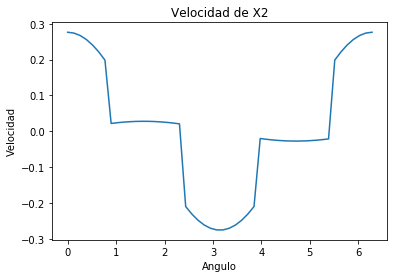

In [6]:
#PASO 4: VELOCIDAD DE X2

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([ 2.76056338,  2.73789909,  2.67027836,  2.55881152,  2.40532888,
        2.21235062,  1.98304545,  0.2158299 ,  0.23606792,  0.2524297 ,
        0.26464657,  0.27251793,  0.27591454,  0.27478061,  0.26913477,
        0.25906973,  0.24475075,  0.22641294,  0.20435743, -2.10203002,
       -2.31360436, -2.48718921, -2.61993428, -2.7096599 , -2.75489278,
       -2.75489018, -2.70965215, -2.6199215 , -2.48717161, -2.31358224,
       -2.10200373, -0.20436016, -0.22641526, -0.24475262, -0.25907113,
       -0.26913567, -0.274781  , -0.27591441, -0.27251729, -0.26464542,
       -0.25242806, -0.23606582, -0.21582737,  1.98307367,  2.21237488,
        2.40534879,  2.55882675,  2.67028864,  2.73790427,  2.76056338])


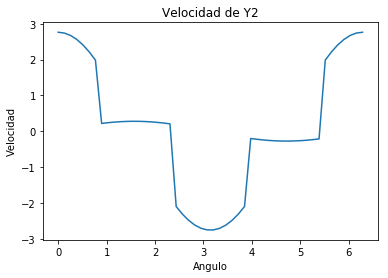

In [7]:
#PASO 4: VELOCIDAD DE Y2

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VY2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VY2 = np.append(VY2, qp[3])

        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX3=
array([ 0.02      ,  0.0198358 ,  0.01934589,  0.01853833,  0.01742636,
        0.01602825,  0.01436696, -0.15636656, -0.1710288 , -0.18288274,
       -0.19173374, -0.19743646, -0.19989727, -0.19907575, -0.1949854 ,
       -0.18769337, -0.17731942, -0.16403387, -0.14805487, -0.12964481,
       -0.10910598, -0.08677561, -0.06302039, -0.03823037, -0.01281261,
        0.01281554,  0.03823326,  0.06302318,  0.08677826,  0.10910844,
        0.12964705,  0.14805685,  0.16403555,  0.17732078,  0.18769439,
        0.19498605,  0.19907603,  0.19989717,  0.19743599,  0.19173291,
        0.18288155,  0.17102728,  0.15636473,  0.01436717,  0.01602843,
        0.01742651,  0.01853844,  0.01934597,  0.01983584,  0.02      ])


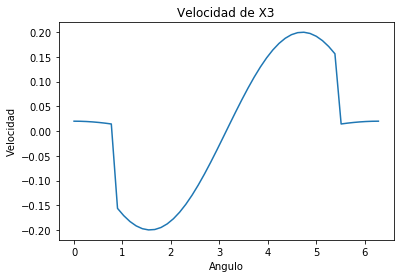

In [8]:
#PASO 4: VELOCIDAD DE X3

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VX3 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VX3 = np.append(VX3, qp[4])

        i=i+1
      
    print ("VX3=")
    pprint.pprint(VX3)
 
    plt.plot(th,VX3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X3')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY3=
array([ 0.2       ,  0.198358  ,  0.19345894,  0.18538328,  0.17426362,
        0.16028255,  0.14366962, -1.56366558, -1.71028801, -1.82882743,
       -1.91733741, -1.97436462, -1.99897266, -1.99075748, -1.94985396,
       -1.87693374, -1.77319417, -1.64033868, -1.48054874, -1.29644811,
       -1.09105975, -0.86775613, -0.63020391, -0.38230372, -0.12812608,
        0.1281554 ,  0.38233256,  0.6302318 ,  0.86778261,  1.09108438,
        1.29647049,  1.48056849,  1.64035549,  1.77320777,  1.87694389,
        1.94986049,  1.9907603 ,  1.99897172,  1.97435993,  1.91732905,
        1.82881554,  1.71027278,  1.56364726,  0.14367166,  0.1602843 ,
        0.17426507,  0.18538439,  0.19345969,  0.19835837,  0.2       ])


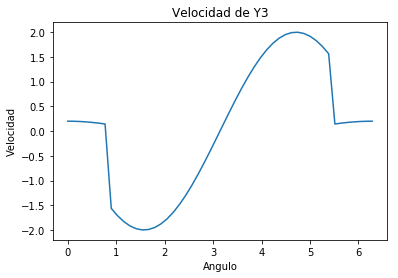

In [9]:
#PASO 4: VELOCIDAD DE Y3

def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VY3 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[6] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp[7] = 1

        resuelve_prob_velocidad(q,meca)
    
        VY3 = np.append(VY3, qp[5])

        i=i+1
      
    print ("VY3=")
    pprint.pprint(VY3)
 
    plt.plot(th,VY3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y3')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

AX1=
array([-30.4       , -29.77030242, -28.02621676, -25.29136026,
       -21.76201985, -17.69402724, -13.3856147 ,   0.75689326,
         0.83440839,   0.89822248,   0.94728772,   0.98079844,
         0.99820441,   0.99921981,   0.98382798,   0.95228164,
         0.90509879,   0.84305417,   0.76716656, -30.77935199,
       -36.53954689, -41.63085766, -45.75325204, -48.66296706,
       -50.18802878, -50.23919975, -48.81564348, -46.00493785,
       -41.97743757, -36.97535277, -31.29725448,  -0.71339249,
        -0.79729339,  -0.8681027 ,  -0.92465772,  -0.96602982,
        -0.99153966,  -1.00076837,  -0.99356441,  -0.97004608,
        -0.93059954,  -0.87587251,  -0.80676362, -13.94264862,
       -18.17299309, -22.15502511, -25.59192689, -28.22938922,
       -29.87273033, -30.39999412])


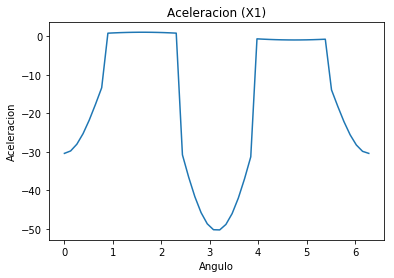

In [10]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    AX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AX1 = np.append(AX1, qpp[0])

        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX1)	
 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY1=
array([-1.        , -0.99690507, -0.97744092, -0.94192713, -0.89094686,
       -0.82533719, -0.74617545, -0.10038433, -0.1129842 , -0.12360281,
       -0.13185822, -0.13745081, -0.14017895, -0.13994945, -0.1367823 ,
       -0.13080925, -0.12226648, -0.1114816 , -0.0988561 ,  0.73552069,
        0.81627018,  0.88361648,  0.93645375,  0.9739144 ,  0.99538333,
        1.00050802,  0.98920432,  0.96165783,  0.91832088,  0.85990505,
        0.78736954,  0.04919921,  0.0525526 ,  0.05505319,  0.0568843 ,
        0.05820323,  0.05912639,  0.05971837,  0.05998566,  0.05987549,
        0.05927983,  0.05804442,  0.05598193, -0.69053139, -0.77749751,
       -0.85169709, -0.91191176, -0.9571528 , -0.98667734, -1.00000059])


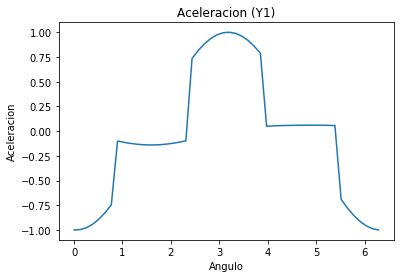

In [11]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    
    AY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)	
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AX2=
array([ 4.57648544,  4.48178817,  4.21844717,  3.80564357,  3.273717  ,
        2.66196761,  2.01582275, -0.09555444, -0.10449246, -0.11175935,
       -0.11731236, -0.12112104, -0.12316358, -0.12342441, -0.12189323,
       -0.11856557, -0.1134449 , -0.10654606, -0.09789974,  4.21747813,
        5.01311691,  5.71837573,  6.29272133,  6.70318059,  6.92624494,
        6.94921863,  6.77094544,  6.40187864,  5.86348967,  5.18704211,
        4.41178855,  0.10630257,  0.11965513,  0.13103774,  0.14018569,
        0.1468841 ,  0.15097544,  0.15236515,  0.15102485,  0.14699315,
        0.14037401,  0.13133267,  0.12008939,  2.09271493,  2.7280843 ,
        3.32796833,  3.84713489,  4.24649406,  4.49592787,  4.57648463])


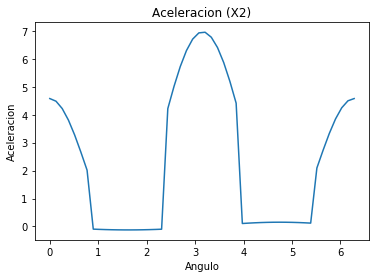

In [12]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    
    AX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX2=")
    pprint.pprint(AX2)	
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AY2=
array([45.11320591, 44.17688935, 41.5747509 , 37.49655623, 32.2424416 ,
       26.20114684, 19.82196124, -1.0276998 , -1.1312462 , -1.21629566,
       -1.28161078, -1.32624695, -1.34955778, -1.35119887, -1.3311304 ,
       -1.28961879, -1.22723741, -1.14486564, -1.04368579, 42.27796284,
       50.10074867, 56.99680101, 62.57102632, 66.50476286, 68.5741007 ,
       68.66263347, 66.76803527, 63.00215599, 57.5846296 , 50.83029212,
       43.13100638,  0.99833558,  1.11714459,  1.21758754,  1.29789275,
        1.35664217,  1.39279934,  1.40572965,  1.3952125 ,  1.36144532,
        1.30503924,  1.22700657,  1.12874019, 20.59087346, 26.86230454,
       32.78494663, 37.91146278, 41.85521514, 44.31828398, 45.11319779])


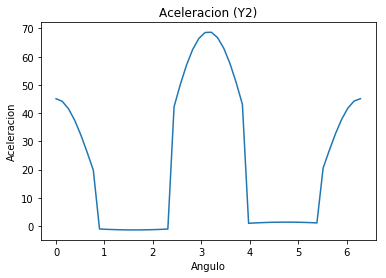

In [13]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    
    AY2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AY2 = np.append(AY2, qpp[3])

        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AX3=
array([-0.1404    , -0.13942986, -0.13554472, -0.12890334, -0.11976617,
       -0.10848112, -0.09546491,  0.75689326,  0.83440839,  0.89822248,
        0.94728772,  0.98079844,  0.99820441,  0.99921981,  0.98382798,
        0.95228164,  0.90509879,  0.84305417,  0.76716656,  0.62229509,
        0.52370868,  0.41652294,  0.30249788,  0.18350578,  0.06150052,
       -0.06151459, -0.18351963, -0.30251127, -0.41653565, -0.5237205 ,
       -0.62230584, -0.71339249, -0.79729339, -0.8681027 , -0.92465772,
       -0.96602982, -0.99153966, -1.00076837, -0.99356441, -0.97004608,
       -0.93059954, -0.87587251, -0.80676362, -0.0899011 , -0.10369772,
       -0.11584171, -0.12590222, -0.1335162 , -0.13840724, -0.14040006])


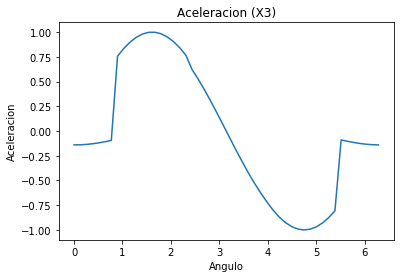

In [14]:
#PASO 5: ACELERACION DE X3

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    
    AX3 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AX3 = np.append(AX3, qpp[4])

        i=i+1
      
    print ("AX3=")
    pprint.pprint(AX3)	
 
    plt.plot(th,AX3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X3)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AY3=
array([-1.        , -0.99690507, -0.97744092, -0.94192713, -0.89094686,
       -0.82533719, -0.74617545, 32.26393819, 37.88744324, 42.7627835 ,
       46.60232298, 49.17895252, 50.34055037, 50.01966302, 48.23777734,
       45.10390696, 40.80758545, 35.60672255, 29.81111372, 23.19880585,
       17.26024173, 11.77053654,  7.03626423,  3.31123479,  0.78080971,
       -0.44926548, -0.3587966 ,  0.98652782,  3.44041468,  6.7864927 ,
       10.75338253, 15.00611406, 19.20380397, 23.07605738, 26.33489811,
       28.7394569 , 30.11218175, 30.35078454, 29.43513692, 27.4286612 ,
       24.47412386, 20.78410798, 16.62679067, -0.69053139, -0.77749751,
       -0.85169709, -0.91191176, -0.9571528 , -0.98667734, -1.00000059])


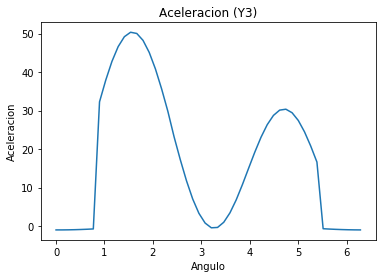

In [15]:
#PASO 5: ACELERACION DE Y3

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    
    AY3 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[6] = 1  #inicializar qp en 0 con qpp[6] = 1 rad/s**2
        qpp[7] = 1

        resuelve_prob_aceleracion(q,meca)
        
        
        AY3 = np.append(AY3, qpp[5])

        i=i+1
      
    print ("AY3=")
    pprint.pprint(AY3)	
 
    plt.plot(th,AY3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y3)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)